In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [1]:
#stepik - Anonymous 523932307

In [11]:
#импорт библиотек
import imageio.v2 as imageio
import torch
import os
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
from torch import nn
import pandas as pd
from PIL import Image
from IPython.display import display, Image
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [12]:
train_path = '/kaggle/input/journey-springfield/train/simpsons_dataset'
test_path = '/kaggle/input/journey-springfield/testset/testset'

In [13]:
#посмотрим количество изображений в каждом классе
for path, dir_list, file_list in os.walk(train_path):
    print(f'Class - {path.split("/")[-1]}')
    print(f' -- Number of files {len(file_list)}')

Class - simpsons_dataset
 -- Number of files 0
Class - rainier_wolfcastle
 -- Number of files 45
Class - maggie_simpson
 -- Number of files 128
Class - krusty_the_clown
 -- Number of files 1206
Class - waylon_smithers
 -- Number of files 181
Class - professor_john_frink
 -- Number of files 65
Class - fat_tony
 -- Number of files 27
Class - ralph_wiggum
 -- Number of files 89
Class - otto_mann
 -- Number of files 32
Class - martin_prince
 -- Number of files 71
Class - barney_gumble
 -- Number of files 106
Class - ned_flanders
 -- Number of files 1454
Class - patty_bouvier
 -- Number of files 72
Class - sideshow_mel
 -- Number of files 40
Class - marge_simpson
 -- Number of files 1291
Class - abraham_grampa_simpson
 -- Number of files 913
Class - selma_bouvier
 -- Number of files 103
Class - mayor_quimby
 -- Number of files 246
Class - disco_stu
 -- Number of files 8
Class - lionel_hutz
 -- Number of files 3
Class - troy_mcclure
 -- Number of files 8
Class - agnes_skinner
 -- Number of f

Несбалансированные классы

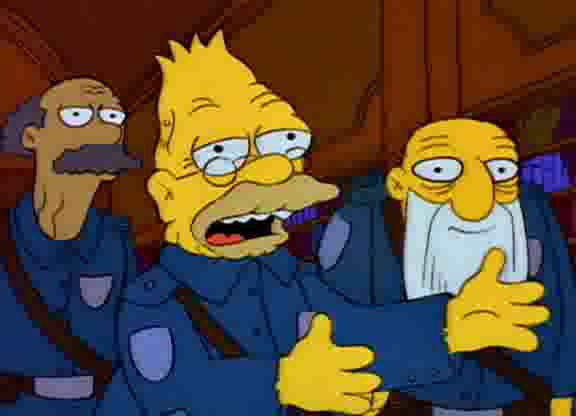

In [14]:
#выведем любое изображение
display(Image(filename=r'/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0007.jpg'))

**AUGMENTATION**

Увеличю набор данных с помощью аугментации. Использовать я для этого буду albumentations

In [15]:
#две разные аугментации
aug1_transform =  A.Compose(
    [
        A.RandomRotate90(always_apply=True),
        A.CoarseDropout(max_width=30, max_height=30, always_apply = True),
        A.Defocus(always_apply = True)
    ])
aug2_transform =  A.Compose(
    [
        A.Downscale(always_apply=True),
        A.Spatter(always_apply = True),
        A.VerticalFlip(always_apply=True)
    ])

Посмотрим как меняет изображения

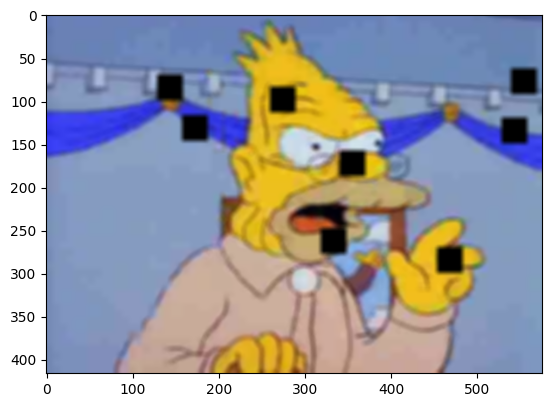

In [16]:
#1
plt.imshow(aug1_transform(image = imageio.imread(os.path.join(r'/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0005.jpg')))["image"])

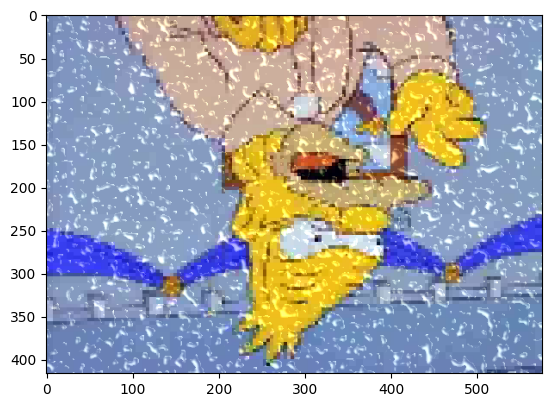

In [17]:
#2
plt.imshow(aug2_transform(image = imageio.imread(os.path.join(r'/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0005.jpg')))["image"])

**Preprocessing**

Создам список преобразований(изменение размера, нормализация)

In [18]:
transform = v2.Compose(
          [  v2.ToImage(),
             v2.Resize([64, 64]),
              v2.ToDtype(torch.float32, scale=True),
              v2.Normalize(mean = (0.485, 0.456, 0.406),
                       std =  (0.229, 0.224, 0.225))]
)

**Dateset**

In [19]:
#создадим пользовательский датасет
class CustomDataset(Dataset):
    def __init__(self, path_, transform_=None, aug = None):
        self.path_ = path_
        self.transform_ = transform_
        self.aug = aug
        self.data_list = []
        self.len_dataset = 0

        for path_dir, dir_list, file_list in os.walk(path_):
          if path_dir == path_:
            self.classes = dir_list
            self.index_of_class = { cls : i for i, cls in enumerate(sorted(self.classes))}
            continue

          cls = path_dir.split('/')[-1]
          for name_file in file_list:
            file_path = os.path.join(path_dir, name_file)
            self.data_list.append((file_path, self.index_of_class[cls]))
          self.len_dataset += len(file_list)
    def __len__(self):
        return self.len_dataset

    def __getitem__(self, idx):
        file_path, label = self.data_list[idx]
        data = imageio.imread(file_path)
        if self.aug is not None:
            data = self.aug(image=data)["image"]
        if self.transform_ is not None:
            data = self.transform_(data)
        return data, label

In [20]:
#создадим три датасета (два с аугментацией, один без)
train_main_data = CustomDataset(
    path_=train_path,
    transform_ = transform
    
)
train_agg1_data = CustomDataset(
    path_=train_path,
    transform_ = transform,
    aug = aug1_transform
    
)
train_agg2_data = CustomDataset(
    path_=train_path,
    transform_ = transform,
    aug = aug2_transform
    
)

In [21]:
#объединим
train_data = torch.utils.data.ConcatDataset([train_agg1_data, train_main_data, train_agg2_data])

In [22]:
#проверим количество
len(train_data)

62799

In [23]:
#разделим на тестовые и валидационные
train_data, valid_data = torch.utils.data.random_split(train_data, [0.8, 0.2])

In [24]:
#количество изображений
len(train_data), len(valid_data)

(50240, 12559)

**DataLoader**

In [25]:
#создадим объект dataloader для test и train
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

**MY MODEL**

Создам свою модель

In [26]:
class Springfield(torch.nn.Module):
    def __init__(self):        
            super(Springfield, self).__init__()  
            self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size=(3, 3))
            self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))  
            self.norm1 = nn.BatchNorm2d(4)
            self.conv2 = nn.Conv2d(in_channels = 4, out_channels = 12, kernel_size=(6, 6))
            self.norm2 = nn.BatchNorm2d(12)
            self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
            self.flat = nn.Flatten()
            self.fc1 = torch.nn.Linear(2028, 1000)           
            self.fc2 = torch.nn.Linear(1000, 500)
            self.fc3 = torch.nn.Linear(500, 100)
    def forward(self, x):
            x = nn.functional.relu(self.conv1(x))
            x = self.pool1(x)
            x = self.norm1(x)
            x = nn.functional.relu(self.conv2(x))
            x = self.norm2(x)
            x = self.pool2(x)
            x = self.flat(x)
            x = torch.nn.functional.relu(self.fc1(x))
            x = torch.nn.functional.relu(self.fc2(x))
            x = self.fc3(x)
            return x

In [28]:
#создадим объект модели
my_model = Springfield().cuda()

In [45]:
#объявим лосс функцию и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model.parameters())

In [85]:
#обучение
for epoch in range(10):
    my_model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = my_model.forward(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    valid_loss = 0.0
    my_model.eval()
    for inputs, labels in valid_loader:
        outputs = my_model(inputs.cuda())
        loss = criterion(outputs ,labels.cuda())
        valid_loss += loss.item() 
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader)}', end= ' ')
    print(f'Epoch {epoch + 1}, Valid Loss: {valid_loss / len(valid_loader)}')

Epoch 1, Train Loss: 2.160826408027843 Epoch 1, Valid Loss: 1.7240751842556872
Epoch 2, Train Loss: 1.4472915866572387 Epoch 2, Valid Loss: 1.4090486722549207
Epoch 3, Train Loss: 1.0411582772139532 Epoch 3, Valid Loss: 1.2874537945398825
Epoch 4, Train Loss: 0.7720101963372746 Epoch 4, Valid Loss: 1.198155122359997
Epoch 5, Train Loss: 0.6099705198388191 Epoch 5, Valid Loss: 1.1925248524864314
Epoch 6, Train Loss: 0.5111951533396533 Epoch 6, Valid Loss: 1.1499886815317997
Epoch 7, Train Loss: 0.4474750299077884 Epoch 7, Valid Loss: 1.197430595528656
Epoch 8, Train Loss: 0.39651802200230823 Epoch 8, Valid Loss: 1.1633706841674554
Epoch 9, Train Loss: 0.3640283511892246 Epoch 9, Valid Loss: 1.145996994476028
Epoch 10, Train Loss: 0.3400356551122134 Epoch 10, Valid Loss: 1.163929628841768


**Test**

Теперь предскажем результаты на тестовых, создадим датасет

In [29]:
test= '/kaggle/input/journey-springfield/testset/testset'


In [30]:
#создаю функцию  для предсказания значений на тестовых
def get_predict(model, train, trnsform):
    l = []
    path_dir, file_list = list(os.walk(test))[0][0], list(os.walk(test))[0][2]
    for file in file_list:
        data = trnsform(imageio.imread(os.path.join(path_dir, file))).unsqueeze(0).cuda()
        predict = model(data).argmax()
        l.append((file, list(train.dataset.datasets[0].index_of_class.keys())[predict]))
    return l
    

In [136]:
#создание датафрейма
predict_df = pd.DataFrame(get_predict(my_model, train_data, transform), columns=['Id' ,'Expected'])\
.sort_values('Id').reset_index(drop=True)

In [107]:
#сохранение результатов
predict_df.to_csv('/kaggle/working/predictions.csv', index=False)

**Было получено качество 98.8%.** (к слову при последующем запуске, он показал 95%, понятное дело тут уже другие  веса, но такой разницы не ожидала) Попробуем улучить с использованием готовой модели.

**TRANSFER LEARNING**

In [31]:
#загрузим модель с весами
from torchvision.models  import convnext_tiny, ConvNeXt_Tiny_Weights

In [32]:
#создадим объект модели
conv_model = convnext_tiny(ConvNeXt_Tiny_Weights, True)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 147MB/s]  


In [33]:
#посмотрим архитектуру
conv_model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

В выходном слое должно быть 42 нейрона(столько у нас классов).

In [34]:
conv_model.classifier[2].out_features = 42

In [35]:
conv_model = conv_model.cuda()

У нас 7 Sequential блоков. Я заморожу первые два, остальные будут обучаться. 

In [36]:
for param in conv_model.features[:2].parameters():
    param.requires_grad = False

In [37]:
#заново инициализирую оптимизатор
optimizer = torch.optim.Adam(conv_model.parameters())

Пока я не могу обучить данные, так как они должны пройти определенный ряд преобразований. Для этого есть специальный трансформатор

In [38]:
 conv_transform = ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms()

Есть одно НО. Данный трансформатор принимает только тензоры или изображения формата pil. Если использовать наш класс, то   трансформатор будет применяться к массиву, что  он не поддерживает. Решу данную проблему с помощью compose

In [39]:
#будем преобразовывать массив в pil, а потом уже применять трансформатор
conv_transform = v2.Compose(
    
          [  torchvision.transforms.functional.to_pil_image,
              conv_transform
              ]
)

Далее уже создаю датасеты, как делала ранее

In [40]:
train_main_data_conv = CustomDataset(
    path_=train_path,
    transform_ = conv_transform
    
)
train_agg1_data_conv = CustomDataset(
    path_=train_path,
    transform_ = conv_transform,
    aug = aug1_transform
    
)
train_agg2_data_conv = CustomDataset(
    path_=train_path,
    transform_ = conv_transform,
    aug = aug2_transform
    
)

In [41]:
#объединим
train_data_conv = torch.utils.data.ConcatDataset([train_agg1_data_conv, train_main_data_conv, train_agg2_data_conv])

In [42]:
#разделим на тестовые и валидационные
train_data_conv, valid_data_conv = torch.utils.data.random_split(train_data_conv, [0.8, 0.2])

In [43]:
#создадим объект dataloader для test и train
train_loader_conv = DataLoader(train_data_conv, batch_size=64, shuffle=True)
valid_loader_conv = DataLoader(valid_data_conv, batch_size=64, shuffle=True)

In [46]:
#обучение
for epoch in range(10):
    conv_model.train()
    train_loss = 0.0
    for inputs, labels in train_loader_conv:
        optimizer.zero_grad()
        outputs = conv_model.forward(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    valid_loss = 0.0
    conv_model.eval()
    for inputs, labels in valid_loader_conv:
        outputs = conv_model(inputs.cuda())
        loss = criterion(outputs ,labels.cuda())
        valid_loss += loss.item() 
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader_conv)}', end= ' ')
    print(f'Epoch {epoch + 1}, Valid Loss: {valid_loss / len(valid_loader_conv)}')

Epoch 1, Train Loss: 1.0320839998733466 Epoch 1, Valid Loss: 0.30152928679803304
Epoch 2, Train Loss: 0.23184898825967387 Epoch 2, Valid Loss: 0.24846866431877698
Epoch 3, Train Loss: 0.1712354852628129 Epoch 3, Valid Loss: 0.1574403561680072
Epoch 4, Train Loss: 0.1355581177635842 Epoch 4, Valid Loss: 0.15495640796793597
Epoch 5, Train Loss: 0.11594265444251667 Epoch 5, Valid Loss: 0.17587002280740266
Epoch 6, Train Loss: 0.10387911620241394 Epoch 6, Valid Loss: 0.14086118503591888
Epoch 7, Train Loss: 0.09006899065355871 Epoch 7, Valid Loss: 0.12345705834822493
Epoch 8, Train Loss: 0.08312226058114439 Epoch 8, Valid Loss: 0.11037802892893099
Epoch 9, Train Loss: 0.07717764066119981 Epoch 9, Valid Loss: 0.12057187430250936
Epoch 10, Train Loss: 0.06769341622244947 Epoch 10, Valid Loss: 0.12568737006554767


Видно, как быстро модель обучается на тренировочных и медленно на валидационных. Тут дело в переобучении

Предскажем на тестовых

In [47]:
#создание датафрейма
conv_df = pd.DataFrame(get_predict(conv_model, train_data_conv, conv_transform), columns=['Id' ,'Expected'])\
.sort_values('Id').reset_index(drop=True)

In [48]:
#сохраним результаты
conv_df.to_csv('/kaggle/working/convpredictions.csv', index=False)

В итоге получили практически такой же результат 98.7%. Думаю, если еще дообучить модель она покажет еще больший результат.